# IMPORT LIBRARIES

In [1]:
import json, requests
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim
import folium 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib_venn import venn2
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans

print('Libraries Imported!')

Libraries Imported!


# NEWYORK DATA

In [43]:
with open('newyork_data.json') as f:
    ny_json = json.load(f)

# relevant information is in 'features' key
ny_json = ny_json['features']
#let's make empty dataframe and put the useful information of json data into dataframe
cols = ['Borough', 'Neighbourhood', 'Latitude', 'Longitude']
ny_df = pd.DataFrame(columns = cols)
for data in ny_json:
    borough = data['properties']['borough']
    neigh   = data['properties']['name']
    lat_lon = data['geometry']['coordinates'] # now it'll return list
    lon, lat = lat_lon[0], lat_lon[1]
    
    ny_df = ny_df.append({'Borough': borough,'Neighbourhood': neigh, 'Latitude': lat,
                          'Longitude': lon}, ignore_index=True)
    
ny_df.head()

,Borough,Neighbourhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


# TORANTO DATA

In [44]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
source = requests.get(url).text
soup = BeautifulSoup(source)

table_data = soup.find('div', class_='mw-parser-output')
table = table_data.table.tbody

columns = ['Postal Code', 'Borough', 'Neighbourhood']
data = dict({key:[]*len(columns) for key in columns})

for row in table.find_all('tr'):
    for i,column in zip(row.find_all('td'),columns):
        i = i.text
        i = i.replace('\n', '')
        data[column].append(i)
        
toronto_df = pd.DataFrame.from_dict(data=data)[columns]

toronto_df = toronto_df[toronto_df['Borough'] != 'Not assigned'].reset_index(drop = True)

# making corresponding Borough as Neighbourhood: where Neighbourhood is 'Not assigend'
p, b, n = [], [], []
for postcode, borough, neigh in zip(toronto_df['Postal Code'], toronto_df['Borough'], toronto_df['Neighbourhood']):
    p.append(postcode)
    b.append(borough)
    if neigh == 'Not assigned':
        n.append(borough)
    else:
        n.append(neigh)

toronto_df = pd.DataFrame({'Postal Code': p, 'Borough': b, 'Neighbourhood':n})[columns]

#merging the rows, where Postal Code and Borough is same and Neighbourhoods will be seperated by ','
# :https://stackoverflow.com/a/27298308
toronto_df = toronto_df.groupby(['Postal Code', 'Borough'])['Neighbourhood'].apply(', '.join).reset_index()

latlon = pd.read_csv('Geospatial_Coordinates.csv')
toronto_df = pd.merge(toronto_df, latlon, how= 'inner', on = 'Postal Code')
toronto_df.head(5)

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


# FOURSQUARE API

In [45]:
CLIENT_ID = 'KMIVHYPR3MQUWVLADERMDDFIYDUR21XSRLUIDZMESFESYZSR' # your Foursquare ID
CLIENT_SECRET = 'KGS4FFJ1ZJ5YQ2GQTULIFHRIODVNGSD04SG5NN4NTFQEAQ5A' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100

In [46]:
def get_near_by_venues(names, latitudes, longitudes, radius= 1000):    
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'\
        .format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)    

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(name, lat, lng, 
                             v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'],
                             v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue in venues_list for item in venue])
    nearby_venues.columns = ['Neighbourhood','Neighbourhood Latitude', 'Neighbourhood Longitude', 
                             'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return nearby_venues

In [47]:
def explore_borough(df, borough):
    new_df = df[df['Borough'] == borough].reset_index(drop = True)
    venues =  get_near_by_venues(names = new_df['Neighbourhood'],latitudes = new_df['Latitude'],
                                 longitudes = new_df['Longitude'])

    onehot_df = pd.get_dummies(venues[['Venue Category']], prefix= "", prefix_sep= "")

    # # add neighborhood column back to dataframe
    onehot_df['Neighbourhood'] = venues['Neighbourhood']
    # move neighborhood column to the first column
    fixed_columns = [onehot_df.columns[-1]] + list(onehot_df.columns[:-1])
    onehot_df = onehot_df[fixed_columns]
    onehot_df_grouped = onehot_df.groupby('Neighbourhood').mean().reset_index()
    
    onehot_coded_df = pd.merge(new_df, onehot_df_grouped, on = 'Neighbourhood', how = 'left')
    
    return onehot_coded_df

In [48]:
def return_venues_for_boroughs(df):
    col = list(df.columns)
    all_venues = pd.DataFrame()
    for i in df['Borough'].unique():
        new_df = df[df['Borough'] == i]
        print('For borough: ',i)
        a = explore_borough(new_df, i)
        all_venues = pd.concat([a, all_venues], axis = 0, ignore_index = True, sort = True)
    cols = col + [j for j in all_venues.columns if j not in col]
    all_venues = all_venues[cols]
    return all_venues

# GETTING VALUES FOR NEWYORK NEIGHBOURHOOD

In [49]:
try:
    df1 = pd.read_csv('New_York_venue.csv')
except:
    df1 = return_venues_for_boroughs(ny_df)
    df1.fillna(0,  inplace = True)
    df1.to_csv('New_York_venue.csv',  index_label = False)
print('Shape data is: ', df1.shape)
df1.head()

Shape data is:  (306, 475)


,Borough,Neighbourhood,Latitude,Longitude,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Center,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,College Gym,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cruise,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Elementary School,Emergency Room,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Kofte Place,Korean Restaurant,Kosher Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Light Rail Station,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern Greek Restaurant,Molecular G

# GETTING VALUES FOR TORANTO NEIGHBOURHOOD

In [50]:
try:
    df2 = pd.read_csv('Toronto_venue.csv')
except:
    df2 = return_venues_for_boroughs(toronto_df)
    df2.fillna(0, inplace = True)
    df2.to_csv('Toronto_venue.csv',  index_label = False)
print('Shape data is: ', df2.shape)
df2.head()

Shape data is:  (103, 339)


,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Lab,College Quad,College Rec Center,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fireworks Store,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Light Rail Station,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Lab,Pide Place,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski 

# EDA 

# GETTING COMMON THINGS BTW TWO CITIES

In [51]:
print('Leaving {} columns of New York city data\nLeaving {} columns of Toronto city data'
      .format(list(df1.columns[0:4]), list(df2.columns[0:5])))
common = 0
diff_in_NY = 0

for i in df1.columns[4:]:
    if i in df2.columns[5:]:
        common += 1
    else:
        diff_in_NY += 1

print('\nNumber of common venue categories in both data are       :{}\n\
Number of different venue categories in New York city are: {}\n\
Number of different venue catehories in Toronto city are : {}'.format(common, diff_in_NY,
                                                                     len(df2.columns[5:])-common))

Leaving ['Borough', 'Neighbourhood', 'Latitude', 'Longitude'] columns of New York city data
Leaving ['Postal Code', 'Borough', 'Neighbourhood', 'Latitude', 'Longitude'] columns of Toronto city data

Number of common venue categories in both data are       :304
Number of different venue categories in New York city are: 167
Number of different venue catehories in Toronto city are : 30


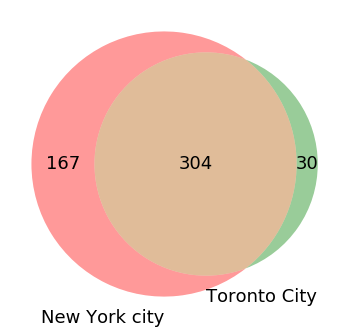

In [52]:
cl1 = set(df1.columns[4:])
cl2 = set(df2.columns[5:])
plt.figure(figsize = (6,6))
out = venn2([set(cl1), set(cl2)], set_labels = ['New York city', 'Toronto City'])
# chnage the text size of matplotlib venn:https://stackoverflow.com/a/29426251
for text in out.set_labels:
    text.set_fontsize(18)
for text in out.subset_labels:
    text.set_fontsize(18)
plt.show()

In [16]:
comm_col = []
for i in df1.columns[4:]:
    if i in df2.columns[5:]:
        comm_col.append(i)

col1 = list(df1.columns[0:4]) + comm_col
col2 = list(df2.columns[0:5]) + comm_col
print('Before reomoving non-common shape of New York: {}, and shape of Toronto is: {}'
      .format(df1.shape, df2.shape))
df1 = df1.loc[:, col1]
df2 = df2.loc[:, col2]
print('After reomoving non-common shape of New York: {}, and shape of Toronto is: {}'
      .format(df1.shape, df2.shape))

Before reomoving non-common shape of New York: (306, 475), and shape of Toronto is: (103, 339)
After reomoving non-common shape of New York: (306, 308), and shape of Toronto is: (103, 309)


# VISUALIZING THE SIMILAR NEIGHBOURHOOD BTW TWO CITIES

In [53]:
def return_ordered_num(n_most_similar):
    a = ['st', 'nd', 'rd']
    c = []
    for i in range(1,20+1):
        if i == 1:
            c.append(str(i)+str(a[i-1]))
        elif i == 2:
            c.append(str(i)+str(a[i-1]))
        elif i == 3:
            c.append(str(i)+str(a[i-1]))
        else:
            c.append(str(i)+'th')
    return c

In [54]:
def most_similar_borough(current_city, current_borough, current_neigh, n_most_similar):
    ny_data = df1.iloc[:,4:]
    toronto_data = df2.iloc[:,5:]
    if current_city.lower() == 'New York'.lower():
        X1 = ny_data.values
        X2 = toronto_data.values
        index = df1.loc[(df1['Borough'] == current_borough) 
                        & (df1['Neighbourhood'] == current_neigh)].index.values.astype(int)[0]
        lat = df1.loc[index]['Latitude']
        lon = df1.loc[index]['Longitude']
    else:
        X1 = toronto_data.values
        X2 = ny_data.values
        index = df2.loc[(df2['Borough'] == current_borough) 
                & (df2['Neighbourhood'] == current_neigh)].index.values.astype(int)[0]
        lat = df2.loc[index]['Latitude']
        lon = df2.loc[index]['Longitude']
    
    a = np.matmul(X1[index], X2.T)
    aa = np.argsort(-a)[0:n_most_similar]
    
    if current_city.lower() == 'New York'.lower():
        my_borough = df2.iloc[aa, :]
    else:
        my_borough = df1.iloc[aa, :]
   
    # for tooltip of map
    c = return_ordered_num(n_most_similar)
    
    current_location_popup = '{}, {}, {}'.format(current_neigh, current_borough, current_city)
    label1 = folium.Popup(current_location_popup, parse_html=True)
    
    my_map = folium.Map(location = [lat, lon], zoom_start = 6)
    folium.CircleMarker([lat, lon], color = 'red', radius = 5,
                        popup = label1, fill_color = '#3186cc', fill_opacity = 1,
                        fill = True, tooltip = 'current location').add_to(my_map)

    # add markers to map
    for lat, lng, label, priority in zip(my_borough['Latitude'], my_borough['Longitude'], 
                                         my_borough['Neighbourhood'], c):
        label = folium.Popup(label, parse_html=True)
        folium.Marker([lat, lng],  popup=label).add_to(my_map)  

    return my_map

### From New York to Toronto

#### Current Location: Bronx, Riverdale, New York

In [19]:
most_similar_borough(current_city = 'New York', current_borough = 'Bronx',
                     current_neigh = 'Riverdale', n_most_similar = 7)

### From New York to Toronto

#### Current Location: Etobicoke, 'Alderwood, Long Branch', Toronto

In [20]:
most_similar_borough(current_city = 'Toronto', current_borough = 'Etobicoke',
                     current_neigh = 'Alderwood, Long Branch', n_most_similar = 10)

# LOADING BOTH CITY DATA IN ORDER TO FIND SIMILAR NEIGHBOURHOOD

In [56]:
NY_grouped = pd.read_excel('NY_grouped.xlsx')
Toronto_grouped = pd.read_excel('Toronto_grouped.xlsx')

### MERGING

In [57]:
L1 = list(NY_grouped.columns)
L2 = list(Toronto_grouped.columns)
L=list(set(L1).intersection(L2))

df=pd.merge(NY_grouped,Toronto_grouped, on=L,how='outer')
cols = [col for col in df.columns if col not in L]
df=df.drop(cols,axis=1)
df.head()

C:\Users\abhar\Anaconda\lib\site-packages\pandas\core\reshape\merge.py:1097: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,


,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,Airport Terminal,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Piano Bar,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Post Office,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Rock Climbing Spot,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Allerton,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.029412,0.0,0.0,0.0,0.0,0.0,0.0,0.029412,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058824,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058824,0.0,0.0,0.0,0.0,0.0,0.058824,0.029412,0.029412,0.0,0.000000,0.029412,0.0,0.029412,0.0,0.0,0.0,0.02941

# PCA

Text(0, 0.5, 'cumulative explained variance')

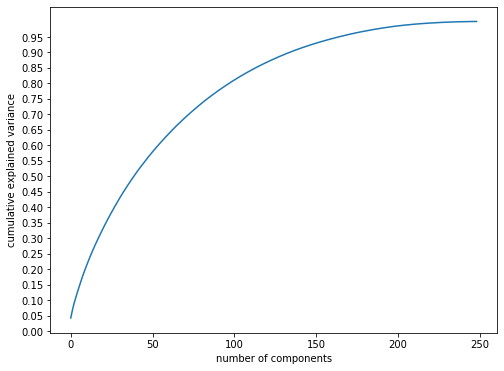

In [23]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
neigh_name = df['Neighborhood']
df_grouped_clustering = df.drop('Neighborhood', 1)

scaler = MinMaxScaler(feature_range=[0, 1])
data_rescaled = scaler.fit_transform(df_grouped_clustering)

pca = PCA().fit(data_rescaled)
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.yticks(np.arange(0, 1.0, step=0.05))
# plt.xticks(np.arange(0, 450, step=30))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [58]:
pca = PCA(n_components=175)
dataset = pca.fit_transform(data_rescaled)


# TO FIND MOST COMMON VENUE IN EACH NEIGHBOURHOOD

In [59]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [60]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = df['Neighborhood']

for ind in np.arange(df.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Allerton,Pizza Place,Spa,Cosmetics Shop,Deli / Bodega,Chinese Restaurant
1,Annadale,Pizza Place,American Restaurant,Sports Bar,Diner,Train Station
2,Arden Heights,Pizza Place,Deli / Bodega,Pharmacy,Coffee Shop,Eastern European Restaurant
3,Arlington,Boat or Ferry,Deli / Bodega,Intersection,Bus Stop,Yoga Studio
4,Arrochar,Bus Stop,Italian Restaurant,Deli / Bodega,Athletics & Sports,Nail Salon


In [61]:
df_grouped_clustering = dataset.copy()
df_grouped_clustering

array([[-0.25152587,  0.09803111,  0.12746262, ...,  0.00936177,
         0.0092891 , -0.01494559],
       [-0.18706789, -0.07267525, -0.05673435, ..., -0.03268149,
         0.00046201,  0.00349685],
       [-0.32025892,  0.09179379, -0.10152222, ...,  0.003749  ,
        -0.05240929,  0.02781   ],
       ...,
       [-0.08165735, -0.15788271, -0.07260399, ...,  0.07499274,
        -0.02543008, -0.03333476],
       [-0.2424111 , -0.19160262, -0.10080103, ...,  0.06457394,
         0.04215841,  0.02927896],
       [-0.20160791, -0.28028335, -0.09967693, ...,  0.0167216 ,
         0.01431961,  0.01470835]])

# K-MEANS

In [62]:
# set number of clusters
kclusters = 5


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=2, copy_x=True).fit(df_grouped_clustering)

# check cluster labels generated for each row in the dataframe
centroids = kmeans.cluster_centers_
labels = kmeans.labels_


## WHICH CLUSTER EVERY VENUE ACCORDINGLY

In [63]:
df_grouped_with_cluster = df.copy()
df_grouped_with_cluster.insert(0, 'Cluster_Labels', kmeans.labels_)


In [64]:
df_grouped_with_cluster.head()

,Cluster_Labels,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,Airport Terminal,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Piano Bar,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Post Office,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Rock Climbing Spot,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,1,Allerton,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.029412,0.0,0.0,0.0,0.0,0.0,0.0,0.029412,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058824,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058824,0.0,0.0,0.0,0.0,0.0,0.058824,0.029412,0.029412,0.0,0.000000,0.029412,0.0,0.029412,0.

In [65]:
df_with_cluster_and_neighborhood = df_grouped_with_cluster[['Cluster_Labels', 'Neighborhood']]

# APPENDING THIS CLUSTERED DATA INTO THE ORIGINAL TO VISULAIZE IT

# FOR NEWYORK CITY

In [66]:
NY_data = pd.read_excel('NY_data.xlsx')
Toronto_data = pd.read_excel('Toronto_data.xlsx')
print('NY_data shape: ', NY_data.shape)
print('Toronto_data shape: ', Toronto_data.shape)

NY_data shape:  (306, 4)
Toronto_data shape:  (103, 5)


In [67]:
NY_data_merged = NY_data[['Neighborhood', 'Latitude', 'Longitude']]
NY_data_merged = NY_data_merged.merge(df_with_cluster_and_neighborhood, on = 'Neighborhood', how = 'left')


In [68]:
NY_data_merged.dropna(inplace = True)
NY_data_merged.head()

,Neighborhood,Latitude,Longitude,Cluster_Labels
0,Wakefield,40.894705,-73.847201,1.0
1,Co-op City,40.874294,-73.829939,1.0
2,Eastchester,40.887556,-73.827806,4.0
3,Fieldston,40.895437,-73.905643,3.0
4,Riverdale,40.890834,-73.912585,3.0


# FOR TORANTO CITY

In [69]:
Toronto_data_merged = Toronto_data[['Neighborhood', 'Latitude', 'Longitude']]
Toronto_data_merged = Toronto_data_merged.merge(df_with_cluster_and_neighborhood, on = 'Neighborhood', how = 'left')

In [70]:
Toronto_data_merged.dropna(inplace = True)
Toronto_data_merged.shape

(100, 4)

In [71]:
address_NY = 'Manhattan, NY'

geolocator = Nominatim(user_agent="NY_explorer")
location = geolocator.geocode(address_NY)
latitude_NY = location.latitude
longitude_NY = location.longitude
print('The geograpical coordinate of Detroit,MI are {}, {}.'.format(latitude_NY, longitude_NY))

The geograpical coordinate of Detroit,MI are 40.7896239, -73.9598939.


In [38]:
# create map
map_NY_with_clusters = folium.Map(location=[latitude_NY, longitude_NY], zoom_start= 11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(NY_data_merged['Latitude'], NY_data_merged['Longitude'], NY_data_merged['Neighborhood'], NY_data_merged['Cluster_Labels']):
    label = folium.Popup(str(poi) + " "  + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_NY_with_clusters)
       
map_NY_with_clusters


In [72]:
address_can = 'East York, Toronto'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address_can)
latitude_tor = location.latitude
longitude_tor = location.longitude
print('The geograpical coordinate of Detroit,MI are {}, {}.'.format(latitude_tor, longitude_tor))

The geograpical coordinate of Detroit,MI are 43.699971000000005, -79.33251996261595.


In [73]:
# create map
map_Toronto_with_clusters = folium.Map(location=[latitude_tor, longitude_tor], zoom_start= 11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_data_merged['Latitude'], Toronto_data_merged['Longitude'], Toronto_data_merged['Neighborhood'], Toronto_data_merged['Cluster_Labels']):
    label = folium.Popup(str(poi) + " "  + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_Toronto_with_clusters)
       
map_Toronto_with_clusters
